In [27]:
import scipy.io as sco
import scipy as sc
from scipy.sparse import coo_matrix 
import matplotlib.pyplot as plt
import copy
import math
import random
import pandas as pd

In [28]:
try:
    del csr
    print("done")
except:
    print("done")

try:
    del csr_middle
    print("done")
except:
    print("done")
    
try:
    del csr_middle_equalmedian
    print("done")
except:
    print("done")

done
done
done


# Load files 

In [29]:
main_mat = sco.mmread("/Users/mathieuouellet/Dropbox/My Mac (mathieu’s MacBook Pro)/Desktop/cell_data/cell_mat.mtx")

In [30]:
type(main_mat)
print(main_mat.shape)
main_mat = main_mat.transpose()
print(main_mat.shape)

(33538, 12531)
(12531, 33538)


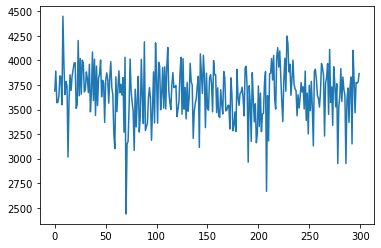

In [31]:
#number of shit in each cell 
row_sum = main_mat.sum(axis=1)[0:300]
plt.plot(row_sum)

<class 'list'>


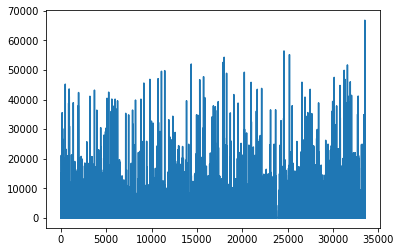

In [32]:
#number of shit for each RNA  
column_sum = main_mat.sum(axis=0).tolist()[0]
print(type(column_sum))
#print(column_sum)
plt.plot(column_sum)
plt.show()

<class 'list'>


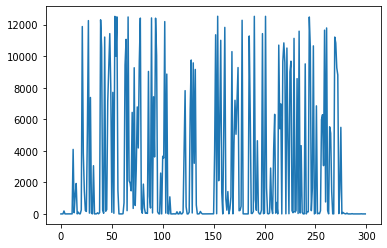

In [33]:
#ratio of non zero
column_nnz = main_mat.getnnz(axis=0).tolist()
print(type(column_nnz))
#print(column_nnz)
plt.plot(column_nnz[0:300])
plt.show()

# Keep gene that are midly expressed/detected ? 

In [78]:
#remove all the one that have less than n_min non zero and the one that have more than n_max non zero
#the goal is to keep the one that arrive quite often but are not always there i.e. not the housekeeping gene
n_min = 3000
n_max = 9000

column_id_to_keep = []

column_nnz = main_mat.getnnz(axis=0).tolist()

for i, val in enumerate(column_nnz):
    if val>=n_min and val<=n_max:
        column_id_to_keep.append(i)

print(len(column_id_to_keep))

csr = main_mat.tocsr()

column_translation_middle = np.array(column_id_to_keep)
csr_middle = csr[:,column_id_to_keep]

print(csr_middle.shape)

5299
(12531, 5299)


In [35]:
import os
path = 'column_translation_middle.txt'

if os.path.exists(path):
    os.remove(path)

    
with open(path, 'w') as f:
    for item in column_translation_middle:
        str_temp = str(item) +   " \n"
        f.write( str_temp )
        
        
csr_middle_txt = "csr_middle.txt"

sc.sparse.save_npz(csr_middle_txt, csr_middle)

In [36]:
#del csr_middle

In [37]:
#del csr

# define Thresholding method and find threshold for each gene

In [38]:
def otso(hist) :
    n = len(hist)
    hist = np.array(hist)
    
    mean_weigth = 1.0/np.sum(hist)
    final_thresh = -1
    final_value = -1
    for t in range(1,n-1): # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        Wb = np.sum(hist[:t]) * mean_weigth
        Wf = np.sum(hist[t:]) * mean_weigth

        mub = np.mean(hist[:t])
        muf = np.mean(hist[t:])

        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
            
    return final_thresh


def max_threshold(hist) :
    n = len(hist)
    max_val = -100000
    id_max = -1
    
    for i in range(1,n-1):
        if hist[i]>max_val:
            max_val = hist[i]
            id_max = i        
            
    return id_max

3 18 0.18
5 18 0.18
6 18 0.18
7 17 0.17
9 17 0.17
11 17 0.17
15 17 0.17
17 18 0.18
24 18 0.18
26 18 0.18
32 15 0.15
34 17 0.17
35 18 0.18
37 18 0.18
43 18 0.18
48 18 0.18
56 18 0.18
58 17 0.17
60 18 0.18
63 15 0.15
65 20 0.2
70 18 0.18
73 15 0.15
74 17 0.17
76 19 0.19
83 18 0.18
84 18 0.18
87 17 0.17
91 18 0.18
95 18 0.18
101 18 0.18
103 18 0.18
107 18 0.18
111 19 0.19
112 18 0.18
113 18 0.18
114 17 0.17
116 18 0.18
121 18 0.18
123 17 0.17
126 16 0.16
128 18 0.18
130 18 0.18
132 18 0.18
133 19 0.19
137 17 0.17
139 18 0.18
140 18 0.18
142 17 0.17
143 17 0.17
146 18 0.18
148 18 0.18
151 16 0.16
153 18 0.18
156 17 0.17
160 17 0.17
161 18 0.18
162 18 0.18
166 18 0.18
167 18 0.18
171 19 0.19
174 17 0.17
175 18 0.18
177 17 0.17
189 17 0.17
190 15 0.15
194 20 0.2
196 17 0.17
198 20 0.2
204 18 0.18
205 18 0.18
208 19 0.19
209 18 0.18
211 19 0.19
220 18 0.18
225 18 0.18
229 18 0.18
230 18 0.18
231 18 0.18
232 19 0.19
235 18 0.18
240 18 0.18
242 17 0.17
244 17 0.17
245 17 0.17
248 18 0.18
249 18

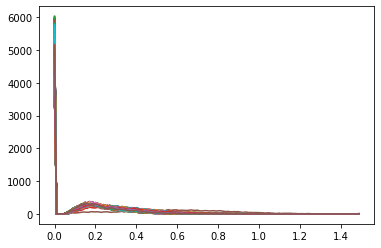

In [39]:
bin_step = 0.01
diff_med_mean = 0.03
threshold_method = max_threshold


bins = np.arange(0, 1.5, bin_step) # fixed bin size

median_list = []
max_list = [] 
mean_list = []
std_list = []

id_mean_equal_median = []
bin_otso_list = []
value_otso_list = []


for i in range(csr_middle.shape[1]):
    data = csr_middle[:,i].todense()

    med_val = np.median(data,axis=0)[0,0]
    mean_val = np.mean(data,axis=0)[0,0]
    max_val = np.max(data,axis=0)[0,0]
    std_val = np.std(data,axis=0)[0,0]
    
    if abs(mean_val-med_val) < diff_med_mean:
        
        median_list.append(med_val)
        mean_list.append(mean_val)
        max_list.append(max_val)
        std_list.append(std_val)
        
        count = [0]*len(bins)
        
        for j in range(data.shape[0]):
            index = round(data[j][0,0]/bin_step)
            if index > len(bins)-1:
                index = len(bins)-1
            
            count[index]+=1
        
        
        bin_id = threshold_method(count[1:]) +1
        print(i,bin_id, bins[bin_id])
        
        plt.plot(bins, count)
        
        id_mean_equal_median.append(i)
        bin_otso_list.append(bins)
        value_otso_list.append(bins[bin_id])
    

#plt.plot(median_list)
#plt.plot(max_list) 
#plt.plot(mean_list)
#plt.show()


In [40]:
csr_middle_equalmedian = csr_middle[:,id_mean_equal_median]
column_translation_middle_equalmedian = column_translation_middle[id_mean_equal_median] 

bin_otso_list = bin_otso_list
value_otso_list = value_otso_list

In [41]:
print(csr_middle_equalmedian.shape)
print(len(column_translation_middle_equalmedian))
print(len(bin_otso_list))
print(len(value_otso_list))

(12531, 1726)
1726
1726
1726


In [42]:
print("A")

A


In [43]:

csr_middle_equalmedian_txt = "csr_middle_equalmedian.txt"

sc.sparse.save_npz(csr_middle_equalmedian_txt, csr_middle_equalmedian)




In [44]:
#del csr_middle_equalmedian

In [45]:
import os
path = 'column_translation_middle_equalmedian.txt'

if os.path.exists(path):
    os.remove(path)

    
    
with open(path, 'w') as f:
    for item in column_translation_middle_equalmedian:
        str_temp = str(item) +   " \n"
        f.write( str_temp )

        

In [ ]:
#del csr_middle

# normalizing each gene  

In [46]:
csr_middle_equalmedian_scaled = copy.copy(csr_middle_equalmedian)


rn = csr_middle_equalmedian.shape[0]
cn = csr_middle_equalmedian.shape[1]

for column in range(cn):
    
    value_otso = value_otso_list[column]
    std_otso = std_list[column]
    print(column, value_otso)
    
    rows,cols = csr_middle_equalmedian[:,column].nonzero()
    
    
        
    for row in rows:
        csr_middle_equalmedian_scaled[row,column] = (csr_middle_equalmedian[row,column] - value_otso)/std_otso
        
    if column%100==0:
        print(csr_middle_equalmedian[row,column])
        

0 0.18
3.4443012860432627
1 0.18
2 0.18
3 0.17
4 0.17
5 0.17
6 0.17
7 0.18
8 0.18
9 0.18
10 0.15
11 0.17
12 0.18
13 0.18
14 0.18
15 0.18
16 0.18
17 0.17
18 0.18
19 0.15
20 0.2
21 0.18
22 0.15
23 0.17
24 0.19
25 0.18
26 0.18
27 0.17
28 0.18
29 0.18
30 0.18
31 0.18
32 0.18
33 0.19
34 0.18
35 0.18
36 0.17
37 0.18
38 0.18
39 0.17
40 0.16
41 0.18
42 0.18
43 0.18
44 0.19
45 0.17
46 0.18
47 0.18
48 0.17
49 0.17
50 0.18
51 0.18
52 0.16
53 0.18
54 0.17
55 0.17
56 0.18
57 0.18
58 0.18
59 0.18
60 0.19
61 0.17
62 0.18
63 0.17
64 0.17
65 0.15
66 0.2
67 0.17
68 0.2
69 0.18
70 0.18
71 0.19
72 0.18
73 0.19
74 0.18
75 0.18
76 0.18
77 0.18
78 0.18
79 0.19
80 0.18
81 0.18
82 0.17
83 0.17
84 0.17
85 0.18
86 0.18
87 0.17
88 0.15
89 0.18
90 0.17
91 0.21
92 0.19
93 0.18
94 0.18
95 0.17
96 0.17
97 0.18
98 0.18
99 0.18
100 0.17
-0.025727717959424672
101 0.17
102 0.18
103 0.19
104 0.18
105 0.18
106 0.18
107 0.17
108 0.2
109 0.18
110 0.17
111 0.18
112 0.18
113 0.17
114 0.18
115 0.17
116 0.17
117 0.18
118 0.17
11

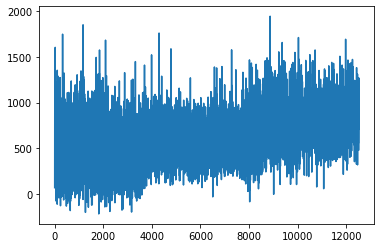

In [47]:
row_sum = csr_middle_equalmedian_scaled.sum(axis=1)
plt.plot(row_sum)

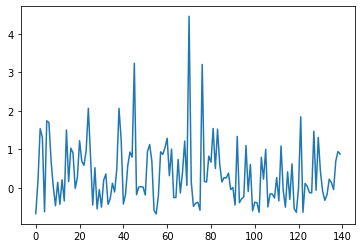

In [48]:
#number of shit for each RNA  
column_test = csr_middle_equalmedian_scaled[:,4].todense()
list_column_test = []

for i in range(200):
    if column_test[i][0,0]!=0:
        list_column_test.append(column_test[i][0,0])

        
        
plt.plot(list_column_test)
plt.show()

In [ ]:
print(csr_middle_equalmedian_scaled.shape)

In [ ]:

csr_middle_equalmedian_scaled_txt = "csr_middle_equalmedian_scaled.txt"

sc.sparse.save_npz(csr_middle_equalmedian_scaled_txt, csr_middle_equalmedian_scaled)


In [ ]:
del csr_middle_equalmedian_scaled

# define the assymetry metric 

In [49]:
def approx_step(x,k):
    
    return 0.5 + 0.5*math.tanh(x*k)

def distance(a,b,hardness,ring_radius,circle_hardness):
    
    val = abs(((a+b)/(abs(a)+abs(b)+0.0000001)))**hardness
    r = math.sqrt(a**2+b**2)
    
    return max(val, (1-approx_step(r-ring_radius,circle_hardness)))


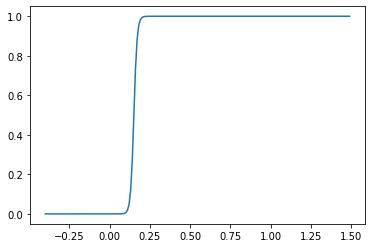

In [50]:
bin_step = 0.01
bins = np.arange(-0.4, 1.5, bin_step)

list_toplot = []


for i in range(len(bins)):
    
    list_toplot.append(approx_step(bins[i]-0.15,50))
    

plt.plot(bins,list_toplot)      
plt.show()

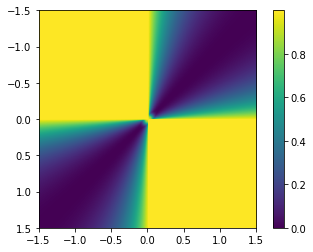

In [51]:

bin_step = 0.01

bins = np.arange(-1.5, 1.5, bin_step) # fixed bin size


mat_toplot = np.zeros((len(bins),len(bins)))


for i in range(len(bins)):
    for j in range(len(bins)):
        
        mat_toplot[i,j] = distance(bins[i],bins[j],2,0.07,25)
        
plt.imshow(mat_toplot,extent=[-1.5, 1.5,1.5,-1.5])
plt.colorbar()


plt.savefig('distance.svg')  



# Keep the cell with both positive and negative (at least 1/3) value of gene

In [52]:
max_n = 12531

good_id = []

for i in range(max_n):
    
    vec1 = csr_middle_equalmedian_scaled[i,:].todense().tolist()
    vec1 = vec1[0]
    
    n_lower = 0
    n_top = 0
    
    for j in range(len(vec1)):
        if vec1[j]<-0.001:
            n_lower+=1 
        if vec1[j]>0.001:
            n_top+=1 
            
            
    if n_lower/n_top >0.33:
        good_id.append(i)
    
print(len(good_id))


6902


In [53]:
csr_middle_equalmedian_scaled_nobadcell = csr_middle_equalmedian_scaled[good_id, :]

In [54]:
print(len(column_translation_middle_equalmedian)) 
print(csr_middle_equalmedian_scaled_nobadcell.shape)

1726
(6902, 1726)


In [55]:
print(csr_middle_equalmedian_scaled_nobadcell.shape)

(6902, 1726)


# Test distance function (assymetry metric)

In [56]:
max_n = 6902
mean_matrix = np.zeros((max_n,max_n))
list_mean = []

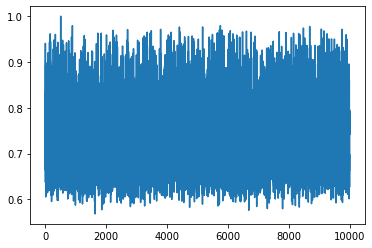

In [57]:
list_of_mean = []

for k in range(10000):
    
    id1 = random.randint(0,max_n-1)
    id2 = random.randint(0,max_n-1)
    
    vec1 = csr_middle_equalmedian_scaled_nobadcell[id1,:].todense().tolist()[0]

    vec2 = csr_middle_equalmedian_scaled_nobadcell[id2,:].todense().tolist()[0]

    vec_dist = []

    for i in range(len(vec1)):

        if vec1[i]!=0 and vec2[i]!=0:
            vec_dist.append(distance(vec1[i],vec2[i],1.7,0.1,25))
        else:
            vec_dist.append(float("Nan"))


    mean = np.nanmean(np.array(vec_dist))

    list_of_mean.append(mean)

plt.plot(list_of_mean)
plt.show()

In [58]:
print(np.mean(np.array(list_of_mean)))
print(np.std(np.array(list_of_mean)))

0.7317766737519406
0.07897804738907395


# Create the mean_matrix of assymetry ratio

In [59]:
less_than_0p6 = []
more_than_0p95 = []

In [60]:
for id1 in range(max_n):
    print(id1)
    vec1 = csr_middle_equalmedian_scaled_nobadcell[id1,:].todense().tolist()[0]

    for id2 in range(max_n): 
        
        if id2 > id1:

            vec2 = csr_middle_equalmedian_scaled_nobadcell[id2,:].todense().tolist()[0]

            vec_dist = []

            for i in range(len(vec1)):

                if vec1[i]!=0 and vec2[i]!=0:
                    vec_dist.append(distance(vec1[i],vec2[i],1.7,0.1,25))
                else:
                    vec_dist.append(float("Nan"))


            mean = np.nanmean(np.array(vec_dist))

            list_mean.append(mean)
            mean_matrix[id1,id2] = mean

            if mean<0.6:
                print(id1,id2)
                less_than_0p6.append((id1,id2))
            if mean>0.95:
                more_than_0p95.append((id1,id2))


0
0 586
0 640
0 1210
0 1425
0 1524
0 1541
0 1573
0 1685
0 1750
0 1789
0 1856
0 1887
0 1913
0 1979
0 2007
0 2021
0 2027
0 2057
0 2159
0 2350
0 2548
0 2872
0 3058
0 3064
0 3111
0 3221
0 3294
0 3397
0 3479
0 4200
0 4248
0 4969
0 4989
0 5125
0 5197
0 5426
0 5537
0 5553
0 5583
0 5672
0 5673
0 5675
0 5725
0 5921
0 5954
0 5956
0 5973
0 6139
0 6216
0 6269
0 6292
0 6482
0 6484
0 6521
0 6558
0 6560
0 6638
1
1 712
1 720
1 768
1 1037
1 1280
1 1288
1 1475
1 1476
1 1491
1 1523
1 1562
1 1619
1 1675
1 1689
1 1787
1 1840
1 1901
1 1935
1 1952
1 1993
1 2106
1 2183
1 2205
1 2231
1 2276
1 2278
1 2302
1 2306
1 2308
1 2400
1 2585
1 2594
1 2600
1 2626
1 2672
1 2702
1 2751
1 2811
1 2872
1 2957
1 3058
1 3064
1 3143
1 3221
1 3422
1 3458
1 3463
1 3469
1 3483
1 3538
1 3548
1 3737
1 3808
1 3854
1 5327
1 5398
1 5580
1 6190
2
3
3 301
3 466
3 665
3 1528
3 1595
3 1952
3 1993
3 2246
3 3458
3 3469
3 3563
3 3577
4
4 155
4 1321
4 1398
4 2904
4 3538
4 3880
4 4033
4 5974
5
5 70
5 378
5 516
5 720
5 768
5 985
5 1032
5 1037
5 1

In [ ]:
import os
txt_0p6_path = 'less_than_0p6.txt'
txt_0p95_path = 'more_than_0p95.txt'

if os.path.exists(txt_0p6_path):
    os.remove(txt_0p6_path)

if os.path.exists(txt_0p95_path):
    os.remove(txt_0p95_path)
    
    
with open(txt_0p6_path, 'w') as f:
    for item in less_than_0p6:
        str_temp = str(item[0]) +  " ; " + str(item[1])+ " \n"
        f.write( str_temp )

        
with open(txt_0p95_path, 'w') as f:
    for item in more_than_0p95:
        str_temp = str(item[0]) +  " ; " + str(item[1])+ " \n"
        f.write( str_temp )


In [ ]:
csr_middle_equalmedian_scaled_nobadcell_txt = "csr_middle_equalmedian_scaled_nobadcell.txt"

sc.sparse.save_npz(csr_middle_equalmedian_scaled_nobadcell_txt, csr_middle_equalmedian_scaled_nobadcell)



In [ ]:
path = 'translate_column.txt'

if os.path.exists(path):
    os.remove(path)
    
with open(path, 'w') as f:
    for item in column_translation_middle_equalmedian:
        str_temp = str(item) + " \n"
        f.write( str_temp )


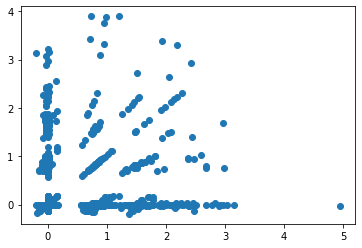

In [450]:
id_tocheck = less_than_0p6[0]
id_tocheck = more_than_0p95[0]

n_test = 6

#print(csr_middle_equalmedian_scaled[less_than_05[n_test][0],:])

vec1 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[0],:].todense().tolist()
vec2 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[1],:].todense().tolist()


plt.scatter(x=vec1,y=vec2 )
plt.show()
    



In [77]:
v1 = [0.5,0.5]
v2 = [0.5,-0.5]
v3 = [-0.5,-0.25]
v4 = [0.25,-0.25]
ls_vec  = [v1,v2,v3,v4]

for id1 in range(len(ls_vec)): 
    for id2 in range(len(ls_vec)): 
        
        vec_dist = []
        for i in range(len(ls_vec[id1])):

            if ls_vec[id1][i]!=0 and ls_vec[id2][i]!=0:
                vec_dist.append(distance(ls_vec[id1][i],ls_vec[id2][i],1.7,0.1,25))
            else:
                vec_dist.append(float("Nan"))

        print(id1,id2,1-np.nanmean(np.array(vec_dist)), sep=" , ")


0 , 0 , 1.6999997720645865e-07
0 , 1 , 0.5000000849999557
0 , 2 , 0.9227561747132401
0 , 3 , 0.4227562880465858
1 , 0 , 0.5000000849999557
1 , 1 , 1.6999997720645865e-07
1 , 2 , 0.5000001133332801
1 , 3 , 2.2666662580217434e-07
2 , 0 , 0.9227561747132401
2 , 1 , 0.5000001133332801
2 , 2 , 2.5499994271704907e-07
2 , 3 , 0.422756344713227
3 , 0 , 0.4227562880465858
3 , 1 , 2.2666662580217434e-07
3 , 2 , 0.422756344713227
3 , 3 , 3.399999081166172e-07


# Get the value (nres/primed) 

In [61]:
df = pd.read_csv('/Users/mathieuouellet/Dropbox/My Mac (mathieu’s MacBook Pro)/Desktop/cell_data/cell_id.txt', delimiter = ";")

In [62]:
list_primed_good = []
list_primed = df['x'].tolist()
for id_tokeep in good_id:
    
    if list_primed[id_tokeep] == "primed":
        list_primed_good.append(1)
    else:
        list_primed_good.append(0)


In [69]:
same_sample_count = 0
diff_sample_count = 0
total_nb_sample = 0

for i in range(100000):
    
    if random.choice(list_primed)==random.choice(list_primed):
        same_sample_count+=1
    else:
        diff_sample_count+=1
        
    total_nb_sample+=1
    

print(same_sample_count/total_nb_sample)
    

0.64599


# Get average of all assymetry matrix 

In [64]:
count_all = 0
sum_all = 0

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            count_all+=1
            sum_all+=mean_matrix[id1,id2]

print(sum_all/count_all)
            

0.7314971694889372


# Compute average mirror fate for lower than assymetry ratio

In [65]:


bin_step = 0.005

bins = np.arange(0.5, 0.73, bin_step)

same_count_list = [0]*len(bins)
diff_count_list = [0]*len(bins)

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            mean = mean_matrix[id1,id2]
            
            for i in range(len(bins)):
                
                if bins[i]>mean:
                    
                    if list_primed_good[id1] == list_primed_good[id2]:
                        same_count_list[i]+=1
                    else:
                        diff_count_list[i]+=1

                
                

NameError: name 'same_count' is not defined

# Compute average mirror fate for higher than assymetry ratio

In [97]:

bin_step = 0.005

bins = np.arange(0.735, 0.95, bin_step)

same_count_list_higher = [0]*len(bins)
diff_count_list_higher = [0]*len(bins)

list_all_mean = []

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            mean = mean_matrix[id1,id2]
            list_all_mean.append(1-mean)
            
            for i in range(len(bins)):
                
                if bins[i]<mean:
                    
                    if list_primed_good[id1] == list_primed_good[id2]:
                        same_count_list_higher[i]+=1
                    else:
                        diff_count_list_higher[i]+=1

                

            

In [ ]:
fffff = [0.1]

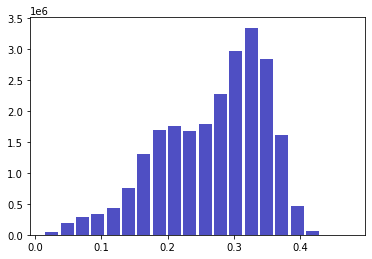

In [98]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=list_all_mean, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.savefig("/Users/mathieuouellet/Dropbox/Boolean_network/FIGURES/OUTPUT/histogram_symmetry.pdf", transparent=True)
 

In [92]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
step_size = 0.1
list_bin = [k*step_size for k in range(1, int(1/step_size)+1)]
value_bin = [0]*len(list_bin)

print(list_bin)
    

# 

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


In [85]:
print(new_same_count_list)

[4, 13, 36, 97, 254, 590, 1361, 3013, 6269, 12113, 22796, 40542, 69081, 112797, 176904, 267353, 388855, 544713, 739225, 971830, 1242060, 1547981, 1885528, 2252395, 2642733, 3052746, 3478369, 3911790, 4350074, 4782015, 5206667, 5618386, 6014461, 6391365, 6749734, 7088302, 7409438, 7715165]


In [441]:
print(diff_count_list_higher)

[3090595, 2951593, 2820540, 2694415, 2572037, 2451735, 2332507, 2212304, 2091903, 1969106, 1845059, 1719803, 1594316, 1468561, 1345320, 1223911, 1106805, 994756, 889171, 791749, 703272, 624119, 554680, 493656, 440963, 395356, 356322, 322728, 293091, 267598, 244999, 224327, 205293, 187117, 169277, 152176, 135526, 118913, 102991, 87660, 73082, 59761, 47950]


In [ ]:
print(same_count_list_higher)

# Plot below and higher curve

### test symmetry of each gene 

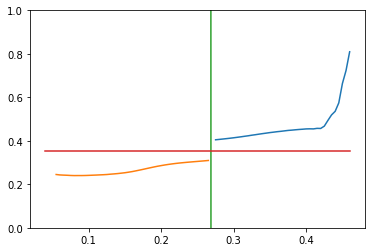

In [75]:

#new_same_count_list = [4, 13, 36, 97, 254, 590, 1361, 3013, 6269, 12113, 22796, 40542, 69081, 112797, 176904, 267353, 388855, 544713, 739225, 971830, 1242060, 1547981, 1885528, 2252395, 2642733, 3052746, 3478369, 3911790, 4350074, 4782015, 5206667, 5618386, 6014461, 6391365, 6749734, 7088302, 7409438, 7715165]
#diff_count_list_higher = [3090595, 2951593, 2820540, 2694415, 2572037, 2451735, 2332507, 2212304, 2091903, 1969106, 1845059, 1719803, 1594316, 1468561, 1345320, 1223911, 1106805, 994756, 889171, 791749, 703272, 624119, 554680, 493656, 440963, 395356, 356322, 322728, 293091, 267598, 244999, 224327, 205293, 187117, 169277, 152176, 135526, 118913, 102991, 87660, 73082, 59761, 47950]

new_bins = np.arange(0.5, 0.73, bin_step)[8:]
new_same_count_list = same_count_list[8:]
new_diff_count_list = diff_count_list[8:]

new_bins_higher = np.arange(0.735, 0.95, bin_step)
new_same_count_list_higher = same_count_list_higher
new_diff_count_list_higher = diff_count_list_higher


ratio = [0]*len(new_same_count_list)
ratio_higher = [0]*len(new_diff_count_list_higher)


for i in range(len(new_same_count_list)):
    
    ratio[i]=new_same_count_list[i]/(new_same_count_list[i]+new_diff_count_list[i])

    
for i in range(len(new_diff_count_list_higher)):
    
    ratio_higher[i]=new_same_count_list_higher[i]/(new_same_count_list_higher[i]+new_diff_count_list_higher[i])
    

revert_new_bins = [1-x for x in new_bins]
revert_new_bins_higher = [1-x for x in new_bins_higher]

revert_ratio = [1-x for x in ratio]
revert_ratio_higher = [1-x for x in ratio_higher]
    
plt.ylim([0, 1])   
plt.plot(revert_new_bins, revert_ratio)
plt.plot(revert_new_bins_higher, revert_ratio_higher)
plt.plot([1-0.7314971694889372,1-0.7314971694889372+0.0001], [1-0,1-1])
plt.plot([1-0.54,1-0.96], [1-0.64599,1-0.64599])

plt.savefig('real_cell.svg')  


In [454]:
main_matrix_todense = csr_middle_equalmedian_scaled_nobadcell.todense()


In [ ]:
del list_mean

In [ ]:
gene_to_check = 200

gene_specific_list = []
gene_specific_distance = np.array((max_n,max_n))

for id1 in range(max_n):

    for id2 in range(max_n): 
        
        if id2 > id1:

            if vec1[i]!=0 and vec2[i]!=0:
                dist = distance(main_matrix_todense[id1,gene_to_check],main_matrix_todense[id2,gene_to_check],1.7,0.1,25)
            else:
                dist = vec_dist.append(float("Nan")
                                       
            gene_specific_distance[id1,id2] = dist
                                       
            gene_specific_list.append(dist)
            

np.nanmean(gene_specific_distance)


In [ ]:
#!/usr/bin/env python
import psutil
# gives a single float value
psutil.cpu_percent()
# gives an object with many fields
psutil.virtual_memory()
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())

In [22]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:100]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                            df: 849.9 KiB
                    column_sum: 262.1 KiB
                    column_nnz: 262.1 KiB
                   list_primed: 98.0 KiB
             column_id_to_keep: 46.1 KiB
     column_translation_middle: 41.5 KiB
                          rows: 28.9 KiB
                          cols: 28.9 KiB
                   median_list: 14.0 KiB
                      max_list: 14.0 KiB
                     mean_list: 14.0 KiB
                      std_list: 14.0 KiB
          id_mean_equal_median: 14.0 KiB
                 bin_otso_list: 14.0 KiB
               value_otso_list: 14.0 KiB
column_translation_middle_equalmedian: 13.6 KiB
                          _i12:  1.3 KiB
                          bins:  1.3 KiB
                         count:  1.2 KiB
              list_column_test:  1.2 KiB
                    coo_matrix:  1.2 KiB
               NamespaceMagics:  896.0 B
                          _i11:  856.0 B
                          _i17:  629.0 B
      

# Old unused code

In [ ]:
same_count = 0
diff_count = 0

for k in range(len(less_than_0p6)):
    
    id_tocheck = less_than_0p6[k]
    
    
    vec1 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[0],:].todense().tolist()[0]
    vec2 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[1],:].todense().tolist()[0]

    vec_dist = []
    
    for i in range(len(vec1)):

        if vec1[i]!=0 and vec2[i]!=0:
            vec_dist.append(distance(vec1[i],vec2[i],1.7,0.1,25))
        else:
            vec_dist.append(float("Nan"))

    mean = np.nanmean(np.array(vec_dist))
    
    if mean<0.565:
    
        if list_primed_good[id_tocheck[0]] == list_primed_good[id_tocheck[1]]:
            same_count+=1

        else:
            diff_count+=1


    
    
print(same_count, diff_count)